In [104]:
#run this everytime an edit is made in utils.py so that we can use the helper functions in this Python Notebook
import importlib
import utils_hw2
importlib.reload(utils_hw2)

<module 'utils_hw2' from '/Users/ivychan/finm-375-fixed-income-deriv-a/ivy-work/homework-2/utils_hw2.py'>

# Case Study - Collared Floater

# Introduction

A **collared floater** pays a floating-rate coupon bounded by a floor and a cap:

$$\max(K_{\text{floor}},\; \min(r,\; K_{\text{cap}}))$$

It can be replicated with three instruments:

| Instrument | Position |
|------------|----------|
| Floating-rate note | +1 |
| Floor (strike = $K_{\text{floor}}$) | +1 |
| Cap (strike = $K_{\text{cap}}$) | -1 |

# Setup


In [105]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import matplotlib.pyplot as plt
from scipy.optimize import fsolve

# Data

Use the data from the following file.
* `../data/fiderivs_2025-03-10.xlsx`

In [106]:
#reading the data from Excel into a pandas Dataframe
import pandas as pd
import numpy as np

path = "data-hw2/fiderivs_2025-03-10.xlsx"
data = pd.read_excel(path)
data

,tenor,swap rates,spot rates,discounts,forwards,flat vols
0,0.25,0.042192,0.042192,0.989562,NaN,NaN
1,0.50,0.040930,0.040923,0.979848,0.039655,0.146300
2,0.75,0.039760,0.039744,0.970775,0.037387,0.168563
3,1.00,0.038833,0.038808,0.962115,0.036001,0.190826
4,1.25,0.037868,0.037830,0.954026,0.033918,0.221870
5,1.50,0.037225,0.037179,0.946002,0.033928,0.244993
6,1.75,0.036817,0.036767,0.937960,0.034293,0.261375
7,2.00,0.036576,0.036524,0.929864,0.034828,0.272194
8,2.25,0.036284,0.036227,0.922060,0.033853,0.278629
9,2.50,0.036134,0.036077,0.914125,0.034724,0.281857


### Parameters


In [107]:
NOTIONAL = 100
T = 5 # Maturity in years
CPNFREQ = 4 # Quarterly coupons
FREQ_CURVE = 4 # Quarterly compounding

BOUND_LOWER = 0.02 # 2% floor
BOUND_UPPER = 0.05 # 5% cap

# 1. Pricing the Components


### 1.1.

A floater with no credit spread trades at par. Record the floater value.

In [108]:
FLOATER_VALUE = NOTIONAL
print(f"Floater Value = {FLOATER_VALUE}")

Floater Value = 100


### 1.2.

Price the **floor** (strike = 2%) and the **cap** (strike = 5%).

Use the flat vol at the 5-year tenor from the `curves` table.

Report both prices.

In [109]:
row_5y = data.loc[np.isclose(data["tenor"], 5.0)].iloc[0]
flat_vol = float(row_5y["flat vols"])

pay_dates = data["tenor"][(data["tenor"] >= 0.5) & (data["tenor"] <= T)].to_numpy()

FREQUENCY = 1 / CPNFREQ  #0.25 for quarterly

floor_price = 0.0
cap_price = 0.0

for pay_date in pay_dates:
    row = data.loc[np.isclose(data["tenor"], pay_date)].iloc[0]
    fwd_rate = float(row["forwards"])
    discount_factor = float(row["discounts"])
    tau = float(pay_date) - FREQUENCY #option expiry

    floor_price += utils_hw2.black_price_floorlet(flat_vol, tau, BOUND_LOWER, fwd_rate, discount_factor, NOTIONAL, FREQUENCY)
    cap_price += utils_hw2.black_price_caplet(flat_vol, tau, BOUND_UPPER, fwd_rate, discount_factor, NOTIONAL, FREQUENCY)

FLOOR_VALUE = floor_price
CAP_VALUE = cap_price

floor_cap_df = pd.DataFrame({
    "Strike": [BOUND_LOWER, BOUND_UPPER],
    "Price": [FLOOR_VALUE, CAP_VALUE]}, index = ["Floor (2%)", "Cap (5%)"])
floor_cap_df

,Strike,Price
Floor (2%),0.02,0.244911
Cap (5%),0.05,0.977314


### 1.3.

Combine the three instruments into the replicating portfolio:
* +1 Floater
* +1 Floor (2%)
* -1 Cap (5%)

Report the NAV of each component and the total portfolio value.

Is the portfolio worth more or less than par? Why?


In [110]:
portfolio_df = pd.DataFrame(
    {"Position": {
            "Floater": +1,
            f"Floor ({BOUND_LOWER:.0%})": +1,
            f"Cap ({BOUND_UPPER:.0%})": -1},
        "NAV": {
            "Floater": float(FLOATER_VALUE),
            f"Floor ({BOUND_LOWER:.0%})": float(FLOOR_VALUE),
            f"Cap ({BOUND_UPPER:.0%})": float(CAP_VALUE)},
    }
)
portfolio_df["Contribution"] = portfolio_df["Position"] * portfolio_df["NAV"]

portfolio_value = float(portfolio_df["Contribution"].sum())

display(portfolio_df.style.format({"NAV": "{:.4f}", "Contribution": "{:.4f}"}))
print(f"Total replicating portfolio value: {portfolio_value:.4f}")

,Position,NAV,Contribution
Floater,1,100.0000,100.0000
Floor (2%),1,0.2449,0.2449
Cap (5%),-1,0.9773,-0.9773


Total replicating portfolio value: 99.2676


Economically, the portfolio is worth less than par because the collar structure sells more valuable optionality than it buys at the chosen strikes and volatility level. 

The long floor provides protection when rates fall below 2%, but at current forwards (roughly mid-3% in your curve) and with a 5-year flat volatility around the high-20% range, the downside protection at 2% is relatively less likely/less “in the money” than the upside risk of rates moving above 5%. By shorting the cap, the investor gives up the possibility of receiving floating coupons above 5% in high-rate scenarios; that forgone upside has meaningful value under the assumed volatility, which is why the cap premium (0.9773) is substantially larger than the floor premium (0.2449). Netting the two option legs, the collar has a negative option value of 0.2449 - 0.9773 = -0.7324, which pulls the total price below the floater’s par value. 

In other words, the collar converts the pure floater into a “truncated” floater -- limited upside, limited downside -- and at these strikes the market prices the lost upside (short cap) as more expensive than the gained downside insurance (long floor), so the resulting instrument must trade at a discount to par.

# 2. Risk Analysis


### 2.1.

Calculate the **duration** of the portfolio numerically by applying a 1bp parallel shock to the spot curve.

Report the duration of each component and the portfolio.

In [139]:
SHOCK = 0.0001

#generate shocked discount factors
curves = data.set_index("tenor")
discounts_base = data["discounts"].to_numpy(dtype = float)
tenors_df = data["tenor"].to_numpy(dtype = float)

discounts_up = utils_hw2.shock_dfs(discounts_base, tenors_df, +SHOCK)
discounts_dn = utils_hw2.shock_dfs(discounts_base, tenors_df, -SHOCK)

def reprice(discount_factors):
    dfs = np.asarray(discount_factors)
    df_prev = np.r_[1.0, dfs[:-1]] #prepend DF(0)=1
    forward_rates = (df_prev / dfs - 1.0) / FREQUENCY
    expiries = np.arange(len(dfs)) * FREQUENCY

    floor_val = 0.0
    cap_val = 0.0

    for df, fwd_rate, expiry in zip(dfs, forward_rates, expiries):
        floor_val += df * utils_hw2.black_price_floorlet(flat_vol, expiry, BOUND_LOWER, fwd_rate, 1.0, NOTIONAL, FREQUENCY)
        cap_val += df * utils_hw2.black_price_caplet(flat_vol, expiry, BOUND_UPPER, fwd_rate, 1.0, NOTIONAL, FREQUENCY)

    return floor_val, cap_val

floor_base, cap_base = reprice(discounts_base)
floor_up, cap_up = reprice(discounts_up)
floor_dn, cap_dn = reprice(discounts_dn)

#floater is always par so no repricing needed
floater_base = floater_up = floater_dn = FLOATER_VALUE

port_base = float(floater_base + floor_base - cap_base)
port_up = float(floater_up + floor_up - cap_up)
port_dn = float(floater_dn + floor_dn - cap_dn)

dur_floater = utils_hw2.calc_numerical_duration(floater_dn, floater_up, floater_base, SHOCK)
dur_floor = utils_hw2.calc_numerical_duration(floor_dn, floor_up, floor_base, SHOCK)
dur_cap = utils_hw2.calc_numerical_duration(cap_dn, cap_up, cap_base, SHOCK)
dur_portfolio = utils_hw2.calc_numerical_duration(port_dn, port_up, port_base, SHOCK)

duration_df = pd.DataFrame({
    "Price": [floater_base, floor_base, cap_base, port_base],
    "Price(+1bp)": [floater_up, floor_up, cap_up, port_up],
    "Price(-1bp)": [floater_dn, floor_dn, cap_dn, port_dn],
    "Duration": [dur_floater, dur_floor, dur_cap, dur_portfolio],
}, index = ["Floater", "Floor (2%)", "Cap (5%)", "Portfolio"])

display(duration_df)

,Price,Price(+1bp),Price(-1bp),Duration
Floater,100.000000,100.000000,100.000000,0.000000
Floor (2%),0.244911,0.242360,0.247493,104.785905
Cap (5%),0.977314,0.988168,0.966543,-110.635576
Portfolio,99.267597,99.254192,99.280950,1.347760


### 2.2.

Calculate the **OAS** of the portfolio.

If the market quotes this note at par (100.00), what parallel shift to the spot curve would match that price?

Use `fsolve` to find the OAS.

In [137]:
from scipy.optimize import fsolve

TARGET = 100.00

def portfolio_price(oas):
    """
    Using the same logic from question 2.1 but takes an OAS as input instead of pre-shocked DFs.
    This helper function prices the collared floater after applying a parallel OAS shift to DFs.
    """
    shifted_dfs = utils_hw2.shock_dfs(discounts_base, tenors_df, oas)
    floor_val, cap_val = reprice(shifted_dfs)

    return float(FLOATER_VALUE + floor_val - cap_val)

def oas_objective(oas):
    """
    Residual: portfolio price - par
    """
    return portfolio_price(oas) - TARGET

#solve for OAS starting from 0
oas_solution = fsolve(oas_objective, x0 = 0.0, full_output = True)
oas = float(oas_solution[0][0])

print(f"OAS: {oas * 10000:.4f} bps")
print(f"Portfolio price at OAS: {portfolio_price(oas):.6f}")

OAS: -59.3472 bps
Portfolio price at OAS: 100.000000


### 2.3.

Plot the portfolio value across a range of interest rate scenarios (shock the spot curve from -300bp to +300bp).

On your plot, mark the current rate, the floor (2%), and the cap (5%).

Describe what you see in terms of convexity.

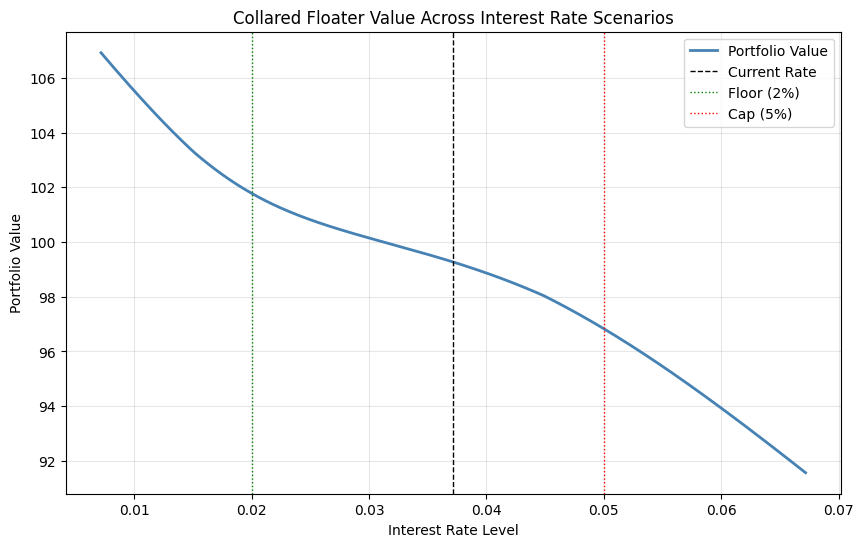

In [140]:
#range of shocks from -300bp to +300bp
shock_range = np.linspace(-0.03, 0.03, 300)
portfolio_values = []

for shock in shock_range:
    shifted_dfs = utils_hw2.shock_dfs(discounts_base, tenors_df, shock)
    df_prev = np.r_[1.0, shifted_dfs[:-1]]
    forward_rates = (df_prev / shifted_dfs - 1.0) / FREQUENCY
    expiries = np.arange(len(shifted_dfs)) * FREQUENCY

    floor_val = 0.0
    cap_val   = 0.0
    for df, fwd_rate, expiry in zip(shifted_dfs, forward_rates, expiries):
        floor_val += df * utils_hw2.black_price_floorlet(flat_vol, expiry, BOUND_LOWER, fwd_rate, 1.0, NOTIONAL, FREQUENCY)
        cap_val += df * utils_hw2.black_price_caplet(flat_vol, expiry, BOUND_UPPER, fwd_rate, 1.0, NOTIONAL, FREQUENCY)
    portfolio_values.append(FLOATER_VALUE + floor_val - cap_val)

#current 5-year spot rate (approximate "current rate" on the x-axis)
current_rate = float(data.loc[T, "spot rates"])
rate_levels = current_rate + shock_range

plt.figure(figsize = (10, 6))
plt.plot(rate_levels, portfolio_values, color = "steelblue", linewidth = 2, label = "Portfolio Value")

#mark current rate, floor, and cap
plt.axvline(current_rate, color = "black", linestyle = "--", linewidth = 1, label = "Current Rate")
plt.axvline(BOUND_LOWER, color = "green", linestyle = ":", linewidth = 1, label = f"Floor (2%)")
plt.axvline(BOUND_UPPER, color = "red", linestyle = ":", linewidth = 1, label = f"Cap (5%)")

plt.xlabel("Interest Rate Level")
plt.ylabel("Portfolio Value")
plt.title("Collared Floater Value Across Interest Rate Scenarios")
plt.legend()
plt.grid(True, alpha = 0.3)
plt.show()

As see in the output above, the portfolio value decreases as interest rates rise, reflecting the dominant duration exposure of the underlying floater component. However, the curvature of the price function clearly changes across rate regions. 

When rates fall toward and below the 2% floor (leftward to the green dashed line), the slope of the curve flattens and the price increases at an increasing rate, indicating positive convexity driven by the long floor position. In this region, the floor gains value rapidly as rates decline, creating strong upward curvature.

In the intermediate region between the 2% floor and the 5% cap, the price profile appears smoother and closer to linear which is consistent with the instrument behaving primarily like a standard floater. We see that convexity is comparatively modest because neither embedded option is strongly in-the-money. Around the current rate (black dashed line), the portfolio displays moderate positive convexity but not the pronounced curvature seen near the floor.

Above the 5% cap (rightward to the red dashed line), the curvature visibly changes again. As rates rise further, the portfolio value declines at an accelerating rate, reflecting the impact of the short cap position. In this region, upside coupon payments are truncated, and the short cap introduces negative convexity characteristics. The slope becomes steeper as rates increase, consistent with the cap’s growing in-the-money exposure.

Overall, the graph confirms that the collared floater exhibits region-dependent convexity: strongly positive convexity when rates are low (floor-dominated), reduced convexity in the middle region (floater-like behavior), and increasingly negative convexity when rates rise above the cap due to the short optionality. This nonlinear shape is precisely what we would expect from truncating both downside and upside rate exposure through a long floor and short cap overlay.

# 3. Stress Test: A +300bp Shock


In 1994, the Federal Reserve raised rates roughly 300bp in under a year, causing large losses on structured note portfolios — most notably Orange County's $1.7 billion loss.

Orange County held primarily **inverse floaters** (coupon = Fixed Rate $-$ Multiplier $\times$ Floating Rate), which are more aggressive than a collared floater. But it is instructive to see what a +300bp shock does to our product.


### 3.1.

Compute the portfolio value after a +300bp parallel shock to the spot curve.

Report the percentage loss.

In [149]:
STRESS_SHOCK = 0.03

floor_val300, cap_val300 = reprice(utils_hw2.shock_dfs(discounts_base, tenors_df, STRESS_SHOCK))
port_val300 = float(FLOATER_VALUE + floor_val300 - cap_val300)

pct_loss = ((port_val300 - port_base) / port_base) * 100

stress_df = pd.DataFrame({
    "Portfolio Value": [port_base, port_val300],
    "% Loss vs 0bp":  [0.0, pct_loss],
}, index = ["0bp", "+300bp"])

stress_df

,Portfolio Value,% Loss vs 0bp
0bp,99.267597,0.000000
+300bp,91.562795,-7.761648


### 3.2.

Orange County's investment pool was leveraged roughly 2.5x.

If we apply the same leverage to the loss from 3.1, what is the leveraged loss?

How does it compare to Orange County's actual 22.3% loss? Why is the gap so large?


In [151]:
LEVERAGE = 2.5

unleveraged_loss = pct_loss #from 3.1, already in percentage terms
leveraged_loss = unleveraged_loss * LEVERAGE

leverage_df = pd.DataFrame({
    "% Loss": [unleveraged_loss, leveraged_loss, -22.3]
}, index = ["Unleveraged loss", f"With {LEVERAGE}x leverage", "Orange County's actual loss"])
leverage_df

,% Loss
Unleveraged loss,-7.761648
With 2.5x leverage,-19.404121
Orange County's actual loss,-22.300000


As seen in the output above, our leveraged loss (~19.5%) falls short of Orange County's actual 22.3% loss for the following possible reasons. 

1. Orange County held inverse floaters (coupon = Fixed - Multiplier × Float), not collared floaters. Inverse floaters have far greater rate sensitivity because their coupon moves inversely with rates, amplifying duration exposure well beyond what a standard collared floater exhibits.
2. Orange County's effective leverage was likely higher than 2.5x in practice due to repo financing and mark-to-market dynamics that forced asset sales at distressed prices, compounding losses beyond the simple linear leverage calculation.
3. Our model uses a parallel shift to a smooth curve whereas the 1994 rate shock involved a rapid, disorderly repricing with liquidity effects and bid-ask widening that our model doesn't capture. 
4. Lastly, volatility spiked during the shock which would have increased the value of the short cap position against Orange County-style holders -- further eroding portfolio values beyond what a static vol model predicts.

# 4. Optional: Volatility Skew

*Requires SABR (Chapter 8).*

### 4.1.

The analysis above uses a single flat vol for both the cap and floor. In practice, implied volatility varies with strike.

Using the SABR parameters below (estimated in `E.8.2. SABR Calibration`), compute the SABR-implied vol at each strike (2% and 5%).

| Parameter | Value |
|-----------|-------|
| beta | 0.25 |
| alpha | 0.0214 |
| nu | 0.60 |
| rho | -0.20 |

Use the 5-year forward rate as the forward.


### 4.2.

Re-price the floor and cap using the SABR-implied vols (one vol per instrument).

Compare the flat-vol portfolio value to the SABR-adjusted portfolio value. Which direction does the skew push the price, and why?


Part 2 (C.9.1) values the same product using binomial trees.